In [3]:
%pip install torch

  Using cached torch-2.7.0-cp312-cp312-win_amd64.whl.metadata (29 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached torch-2.7.0-cp312-cp312-win_amd64.whl (212.5 MB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'c:\\Python312\\Scripts\\torchfrtrace.exe' -> 'c:\\Python312\\Scripts\\torchfrtrace.exe.deleteme'


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import torch
import torch.nn as nn
import pandas as pd

import sys
import os
sys.path.append(os.path.abspath('..'))

from shared.baseline_shared import get_shared_components
from shared.baseline_train import train_model, evaluate_model


In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attention = nn.Linear(input_dim, 1)

    def forward(self, x):
        weights = torch.softmax(self.attention(x), dim=1)
        weighted = (x * weights).sum(dim=1)
        return weighted

class MatchPredictor(nn.Module):
    def __init__(self, input_dim, num_classes=3):
        super().__init__()
        self.input_dim = input_dim
        
        self.num_players = 11
        self.player_feat_dim = 2
        self.team_feat_dim = self.num_players * self.player_feat_dim

        assert input_dim >= 2 * self.team_feat_dim, "Input dim too small."

        self.team_gru = nn.GRU(
            input_size=self.team_feat_dim,
            hidden_size=64,
            batch_first=True,
            bidirectional=True
        )

        self.attention = AttentionLayer(128)

        self.match_context_dim = input_dim - (2 * self.team_feat_dim)
        self.context_branch = nn.Sequential(
            nn.Linear(self.match_context_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 + 64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        home_team = x[:, :self.team_feat_dim]
        away_team = x[:, self.team_feat_dim:2*self.team_feat_dim]
        match_context = x[:, 2*self.team_feat_dim:]

        team_seq = torch.stack([home_team, away_team], dim=1)

        team_outputs, _ = self.team_gru(team_seq)

        team_features = self.attention(team_outputs)

        context_features = self.context_branch(match_context)

        combined = torch.cat([team_features, context_features], dim=1)

        return self.classifier(combined)

[Epoch 0] Loss: 1.0321 | Accuracy: 0.4809
[Epoch 10] Loss: 0.9912 | Accuracy: 0.5163
[Epoch 20] Loss: 0.9808 | Accuracy: 0.5251
[Epoch 30] Loss: 0.9736 | Accuracy: 0.5304
[Epoch 40] Loss: 0.9672 | Accuracy: 0.5351
[Epoch 49] Loss: 0.9624 | Accuracy: 0.5355

=== Classification Metrics ===
Accuracy:       0.5267
Macro Precision: 0.5305
Macro Recall:   0.4440
Macro F1:       0.3959
Weighted Precision: 0.5296
Weighted Recall: 0.5267
Weighted F1:    0.4492

Class-wise Metrics:
Class  Precision  Recall     F1         Support   
0      0.5266      0.8624      0.6539      436       
1      0.5385      0.0283      0.0538      247       
2      0.5263      0.4412      0.4800      272       

Confusion Matrix:
[[376   3  57]
 [189   7  51]
 [149   3 120]]

=== Probability Distribution Metrics ===
KL Divergence (Bookie || Model): 0.0269
['2016-01-02T00:00:00.000000000' '2016-01-03T00:00:00.000000000'
 '2016-01-03T00:00:00.000000000' '2016-01-02T00:00:00.000000000'
 '2016-01-02T00:00:00.000000000' 

{'classification': {'accuracy': np.float64(0.5267015706806283),
  'precision': array([0.52661064, 0.53846154, 0.52631579]),
  'recall': array([0.86238532, 0.02834008, 0.44117647]),
  'f1': array([0.65391304, 0.05384615, 0.48      ]),
  'macro_precision': 0.530462657397642,
  'macro_recall': 0.4439672908869376,
  'macro_f1': 0.3959197324414716,
  'weighted_precision': 0.5295917650609431,
  'weighted_recall': 0.5267015706806283,
  'weighted_f1': 0.4491791486455725,
  'confusion_matrix': array([[376,   3,  57],
         [189,   7,  51],
         [149,   3, 120]]),
  'support': array([436, 247, 272])},
 'kl_divergence': {'kl_divergence': np.float32(0.026947454)},
 'profit_simulation': {'final_bankroll': np.float32(1104.1449),
  'total_profit': np.float32(104.1449),
  'roi': np.float32(10.41449),
  'bets_made': 483,
  'bets_won': 217,
  'win_rate': 0.4492753623188406,
  'bankroll_history': [1000],
  'bet_records': [(np.datetime64('2016-01-03T00:00:00.000000000'),
    np.float32(1005.5133)),

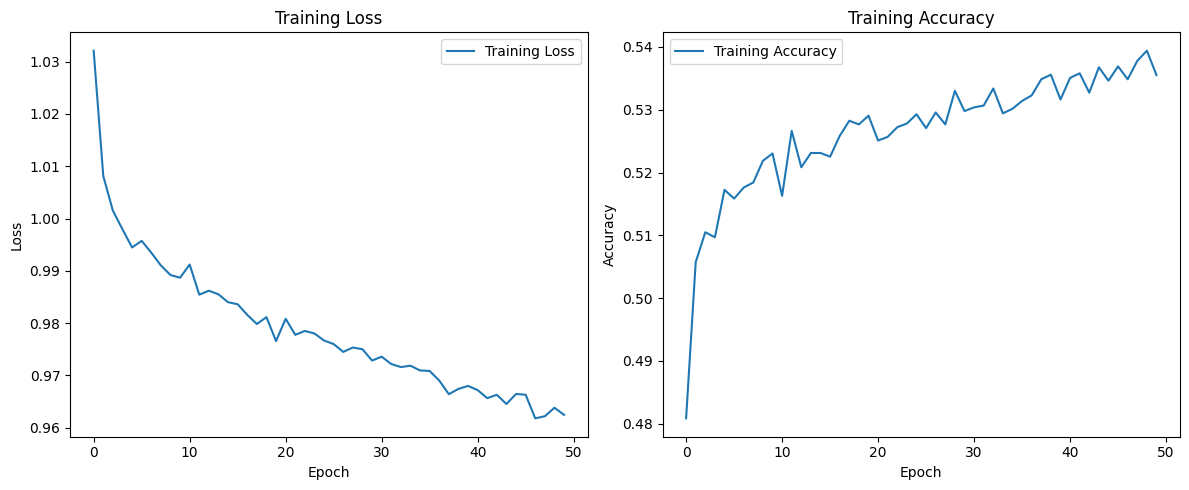

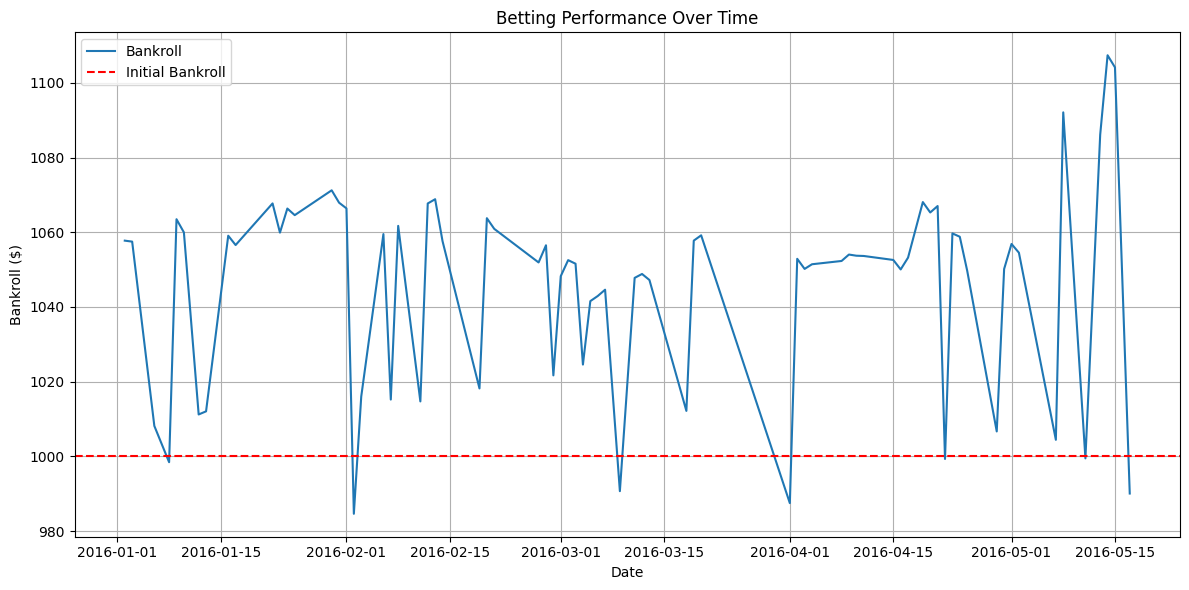

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv("../final_5_league.csv")
components = get_shared_components(df, device)

model = MatchPredictor(input_dim=components['input_dim']).to(device)
optimizer = components['make_optimizer'](model)

df['match_date'] = pd.to_datetime(df['match_date'])
test_dates = df[df['match_date'].dt.year == 2016]['match_date'].values

train_model(
    model,
    components['X_train'],
    components['y_train'],
    optimizer,
    components['criterion'],
    epochs=50
)

evaluate_model(
    model,
    components['X_test'],
    components['y_test'],
    bookie_probs=components['bookie_test'].cpu().numpy(),
    match_dates=test_dates
)